In [23]:
IMG_SIZE = [224, 224]
train_dir = 'PlantVillage\Train'


In [24]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create VGG-Like CNN Model
model = Sequential([
      Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(128, 128, 3)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
  
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
  
      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
  
      GlobalAveragePooling2D(),
      Dense(256, activation='relu'),
      Dropout(0.3),
      Dense(128, activation='relu'),
      Dropout(0.3),
      Dense(15, activation='softmax')
  ])
  

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode="categorical", subset="training"
)
val_data = datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode="categorical", subset="validation"
)

# Model Checkpoint and Early Stopping
checkpoint = ModelCheckpoint("best_simple_vgg_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train Model
start_time = time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Only 5 Epochs
    callbacks=[early_stopping, checkpoint, lr_reduction],
    verbose=1
)
end_time = time.time()
print(f"Training Time: {(end_time - start_time) / 60:.2f} minutes")


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
365/517 ━━━━━━━━━━━━━━━━━━━━ 4:14 2s/step - accuracy: 0.5073 - loss: 1.9067

In [16]:
from tensorflow.keras.models  import load_model
model = load_model("best_simple_vgg_model.h5")
checkpoint = ModelCheckpoint("best_simple_vgg_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_dir,
    validation_data= train_dir,
    epochs=5,  # Continue for 5 more epochs
    callbacks=[early_stopping, checkpoint, lr_reduction],
    verbose=1
)

ValueError: Unrecognized data type: x=PlantVillage\Train (of type <class 'str'>)

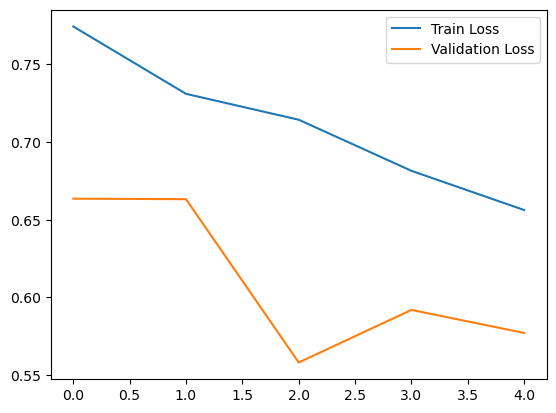

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()